In [1]:
!git clone https://github.com/sutaina/seismic-simulation-wavenet

Cloning into 'seismic-simulation-wavenet'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 140 (delta 0), reused 1 (delta 0), pack-reused 132
Receiving objects: 100% (140/140), 2.07 MiB | 5.34 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [2]:
cd seismic-simulation-wavenet

/home/susanne/Dropbox/Congressos/CursoML_SBGf_2022/Labs/seismic-simulation-wavenet


## Fast approximate simulation of seismic waves with deep learning

Esta atividade é uma cortesia de Ben Moseley. O código original pode ser encontrado aqui:
 https://github.com/benmoseley/seismic-simulation-wavenet


Machine learning workshop

Author: Ben Moseley, Centre for Autonomous Intelligent Machines and Systems, University of Oxford, bmoseley@robots.ox.ac.uk

This workshop reproduces the results of the paper: Fast approximate simulation of seismic waves with deep learning, NeurIPS 2018, B. Moseley, A. Markham and T. Nissen-Meyer.

## Visão geral

A simulação sísmica é crucial para muitas aplicações geofísicas, mas as abordagens tradicionais são computacionalmente caras.

Neste workshop, usaremos deep learning para simular um sismograma sintético.

Mostraremos que isso pode oferecer uma aproximação alternativa e mais  rápida se comparada aos métodos tradicionais de simulação.

## Tarefa

Para este estudo de prova de princípio, consideraremos a simulação de **ondas acústicas** propagando-se em meios sintéticos **em camadas horizontais**.

Especificamente, consideraremos uma única fonte de ponto fixo se propagando através de um modelo de velocidade em camadas horizontalmente com 11 receptores fixos deslocados horizontalmente da fonte, mostrados abaixo.

<img src="figures/example_simulation.png" width="600"><!---include "" for proper github rendering-->

Esquerda: modelo de velocidade de entrada, triângulos mostram as localizações dos receptores. Direita: pressão do campo de onda após 1 s, usando modelagem acústica de Diferenças Finitas (FD), círculo preto mostra a localização fixa da fonte pontual.

Nossa tarefa é a seguinte:

> Dado um modelo de velocidade em camadas selecionado aleatoriamente como entrada, podemos treinar uma rede neural para simular a resposta de pressão registrada em cada local do receptor?

Desejamos que nossa rede neural generalize bem para modelos de velocidade não vistos durante o treinamento. Compararemos nossos resultados com a modelagem FD tradicional.

## Workflow

Usaremos o seguinte fluxo de trabalho para concluir esta tarefa;

- pré-processaremos o perfil de velocidade de entrada em sua série de refletividade correspondente;

- vamos passar isso para uma rede neural profunda com uma arquitetura **WaveNet** para simular as respostas do receptor;

- vamos treinar esta rede com muitos exemplos de simulações de FD de verdade do terreno;

- compararemos a precisão e desempenho computacional da rede treinada com a simulação FD.

Este fluxo de trabalho é mostrado abaixo.

<img src="figures/workflow.png" width="850">

## Seções

Há 5 seções para completar neste caderno. Este é um notebook interativo; durante cada seção, você será solicitado a concluir algumas tarefas curtas de codificação e responder a algumas perguntas à medida que avança.

As seções são as seguintes:

- [Seção 1: Carregamento e exploração de dados](#Seção-1:-Carregamento-e-exploração de dados)

- [Seção 2: Projetando um modelo de aprendizado profundo](#Seção-2:-Projetando-um-modelo de aprendizado profundo)

- [Seção 3: Treinando o modelo](#Seção-3:-Treinando-o-modelo)

- [Seção 4: Avaliação de desempenho](#Seção-4:-Avaliação de desempenho)

- [Seção 5: Inversão sísmica (extra opcional)](#Seção-5:-inversão sísmica-(extra opcional))
Mais sobre o texto original
É necessário fornecer o texto original para ver mais informações sobre a tradução
Enviar feedback
Painéis laterais


In [10]:
# import libraries
import os, time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import main, models, datasets, constants
import io_utils, downloader

import importlib
importlib.reload(datasets)
importlib.reload(models)


<module 'models' from '/home/susanne/Dropbox/Congressos/CursoML_SBGf_2022/Labs/seismic-simulation-wavenet/models.py'>

### 2. Baixando dados

Este notebook requer acesso a um conjunto de dados pré-criado para treinar e testar nossa rede neural profunda, bem como alguns arquivos de modelo de tensorflow pré-treinados.

Por favor, use o código abaixo para baixar esses dados.

Nota: o tamanho do arquivo do conjunto de dados sísmicos é **~600 Mb** e o tamanho do arquivo dos arquivos pré-treinados é **~100 Mb** - certifique-se de ter espaço em disco suficiente antes!


In [5]:
## Download the training data and pretrained model files (~700 Mb total)
io_utils.get_dir("data/")# create data directory
if not os.path.isfile("data/layers_8ms.bin"):# download data
    downloader.get_url(url="https://benmoseley.blog/uploads/DIP/layers_8ms.bin",
                       file_path="data/layers_8ms.bin")
if not (os.path.isfile("data/pretrained.zip") or os.path.isdir("data/pretrained")):# download pretrained model files
    downloader.get_url(url="https://benmoseley.blog/uploads/DIP/pretrained.zip",
                       file_path="data/pretrained.zip")# please unzip this folder after downloading
if os.path.getsize("data/layers_8ms.bin") != 594880000: raise Exception("Try downloading data again, it appears corrupt.")
print("Data downloaded successfully")

Data downloaded successfully



Por favor, **descompacte** os arquivos de modelo pré-treinados após o download.

In [7]:
!unzip data/pretrained.zip

Archive:  data/pretrained.zip
   creating: pretrained/
   creating: pretrained/inverse/
  inflating: pretrained/inverse/constants_inverse.txt  
  inflating: pretrained/inverse/model.ckpt-500000.meta  
  inflating: pretrained/inverse/model.ckpt-500000.index  
  inflating: pretrained/inverse/model.ckpt-500000.data-00000-of-00001  
  inflating: pretrained/inverse/events.out.tfevents.1547662831  
  inflating: pretrained/inverse/constants_inverse.pickle  
  inflating: pretrained/.DS_Store    
   creating: __MACOSX/
   creating: __MACOSX/pretrained/
  inflating: __MACOSX/pretrained/._.DS_Store  
   creating: pretrained/forward/
  inflating: pretrained/forward/events.out.tfevents.1547662771  
  inflating: pretrained/forward/.DS_Store  
   creating: __MACOSX/pretrained/forward/
  inflating: __MACOSX/pretrained/forward/._.DS_Store  
  inflating: pretrained/forward/model.ckpt-500000.meta  
  inflating: pretrained/forward/model.ckpt-500000.index  
  inflating: pretrained/forward/model.ckpt-500000

# Seção 1: carregamento e exploração de dados

Nesta seção, exploraremos o conjunto de dados baixado. Este conjunto de dados contém 20.000 simulações de exemplo que usaremos para treinar e testar nossa rede neural profunda.

Cada simulação de exemplo consiste em um modelo de velocidade em camadas horizontalmente, sua série de refletividade de deslocamento zero correspondente e a pressão registrada em cada local do receptor. A resposta de pressão foi simulada offline usando o modelo de velocidade e modelagem acústica 2D de diferenças finitas. A série de refletividade também foi pré-computada offline para você usando o modelo de velocidade e uma simples conversão de profundidade 1-D em tempo.

> **Tarefa 1:** use `matplotlib` para visualizar alguns dos exemplos.

Observação:

- o modelo de velocidade é amostrado em profundidade com espaçamento de 12,5 m;
- o modelo de refletividade e as gravações do receptor são amostrados no tempo com uma taxa de amostragem de 0,008 s;
- O espaçamento do receptor é de 200 m.

20000
<class 'numpy.ndarray'> (236, 1)
<class 'numpy.ndarray'> (600, 11)


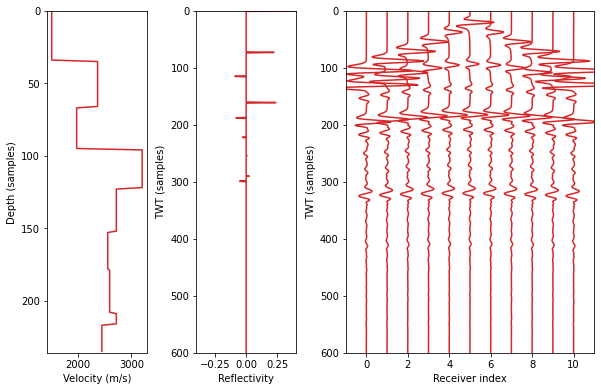

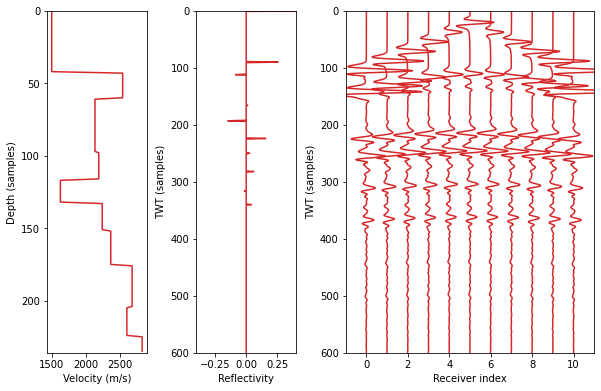

In [12]:
### TODO: run the following code to read the provided dataset into Python.
# Note: data/layers_8ms.bin is a flat binary file containing all of the examples.
# The datasets.SeismicDataset class loads examples from the binary file into numpy arrays.
# The constants.Constants class feeds necessary constants to the SeismicDataset class.

# define constants
c = constants.Constants()
c["DATA_PATH"]="data/layers_8ms.bin"# path to dataset
c["N_EXAMPLES"]=20000# number of examples in dataset
c["VELOCITY_SHAPE"]=(236, 1)# (Number of depth steps, 1)
c["REFLECTIVITY_SHAPE"]=(600, 1)# (Number of time steps, 1)
c["GATHER_SHAPE"]=(600, 11)# (Number of time steps, Number of receivers)

# create a SeismicDataset object
dataset = datasets.SeismicDataset(c)
print(len(dataset))

# get the first example from the dataset
velocity_array, reflectivity_array, gather_array = dataset[0]
print(type(velocity_array), velocity_array.shape)
print(type(gather_array), gather_array.shape)
%matplotlib inline
### TODO: Enter you code to visualise a few of the examples here:

    
plt.close('all')
for i in [10,20]:
    fig = datasets.plot_example(*dataset[i])
    plt.show()



> **Pergunta 1:** que fórmula deve ser usada para converter os modelos de velocidade em suas séries de refletividade (deslocamento zero)?

Nota: um modelo de densidade constante foi usado durante a simulação. Você pode verificar se as séries de refletividade pré-computadas estão corretas calculando suas próprias séries de refletividade e comparando-as.

> *Resposta: a fórmula para o valor da refletividade na incidência normal é*
$$
R = {\rho_{2}v_{2}-\rho_{1}v_{1} \over \rho_{2}v_{2}+\rho_{1}v_{1}}~,
$$
*onde $\rho_{1}$,$v_{1}$ e $\rho_{2}$,$v_{2}$ são as densidades e velocidades na interface.*

> **Tarefa 2:** plote os histogramas de valores de velocidade de camada e espessuras de camada em todo o conjunto de dados.

Nota: todos os modelos de velocidade fornecidos começam em 1500 m/s, o que leva a um pico no histograma de velocidade neste valor.

163219 143219


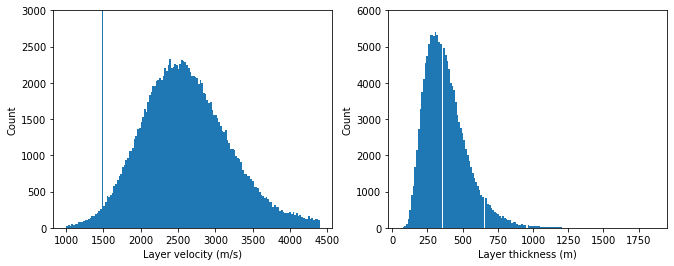

In [13]:
### TODO: Enter you code here:
# Hint: you can use plt.hist to make the histogram

layer_velocities = []
layer_thicknesses = []
for i in range(len(dataset)):
    velocity_array, _, _ = dataset[i]
    v = None
    tstart = 0
    for ival, val in enumerate(velocity_array):
        if v == None: 
            v = val
            layer_velocities.append(v)
        if v != val:
            v = val
            layer_velocities.append(v)
            layer_thicknesses.append(12.5*(ival - tstart))
            tstart = ival
            
layer_velocities = np.array(layer_velocities)
layer_thicknesses = np.array(layer_thicknesses)
print(len(layer_velocities), len(layer_thicknesses))

plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.hist(layer_velocities, bins=150)
plt.xlabel("Layer velocity (m/s)")
plt.ylabel("Count")
plt.ylim(0, 3000)

plt.subplot(1,2,2)
plt.hist(layer_thicknesses, bins=150)
plt.xlabel("Layer thickness (m)")
plt.ylabel("Count")
plt.ylim(0, 6000)
plt.show()




# Seção 2: Projetando um modelo de aprendizado profundo

Vamos agora definir uma rede neural profunda que pode simular as respostas do receptor, dado um modelo de velocidade como entrada.

Para um modelo de velocidade em camadas horizontalmente e receptores com deslocamento horizontal, a resposta de cada receptor é **causalmente correlacionada** à série de refletividade. Mais precisamente, cada amostra de pressão no tempo está correlacionada no máximo com os valores de refletividade de tempos anteriores.

Vamos modelar as respostas do receptor usando uma rede que honre esse relacionamento casual. Aqui, escolheremos um design **WaveNet**, mostrado na figura abaixo. Essa arquitetura foi originalmente projetada para síntese de fala (para mais informações, veja aqui: https://deepmind.com/blog/wavenet-generative-model-raw-audio/).

<img src="figuras/wavenet.png" largura="500">

Este modelo consiste em **camadas convolucionais empilhadas, conectadas casualmente e exponencialmente dilatadas**. O modelo é causal por design e as dilatações exponenciais permitem que o campo de visão da rede aumente exponencialmente com a profundidade da rede.

A entrada para o WaveNet é a série de refletividade pré-processada correspondente ao modelo de velocidade de entrada e a saída do WaveNet é passada para uma **camada convolucional causal final sem ativação** para gerar as previsões de pressão do receptor de saída. Cada canal no tensor de saída corresponde a uma previsão do receptor.


Há uma série de hiperparâmetros-chave para decidir neste modelo, incluindo:

- número de camadas ocultas
- número de canais ocultos
- função de ativação
- comprimento do filtro da camada convolucional final



In [14]:
### TODO: Run the code below to define a WaveNet model, then visualise the graph using Tensorboard.
### TODO: Vary the hyperparameters of the model to see how this affects the model graph.
### TODO: Look through the source code of wavenet.py and try to understand how the WaveNet is defined.
### the WaveNet source code is also available here: https://github.com/benmoseley/simple-wavenet.

# Note:
# The constants.Constants class is used to hold all model hyperparameters
# The models.SeismicWavenet class is used to define a WaveNet model in tensorflow

tf.reset_default_graph()

# define model hyperparameters
c = constants.Constants()
c["NUM_WAVE_BLOCKS"] = 1# number of WaveNet blocks to use
c["WAVE_HIDDEN_CHANNELS"] = 256# number of hidden channels in WaveNet
c["WAVE_RATES"] = [1,2,4,8,16,32,64,128,256]# dilation rates for each convolutional layer
c["WAVE_BIASES"] = False# whether to use biases in the WaveNet
c["WAVE_ACTIVATION"] = tf.nn.relu# activation function
c["CONV_FILTER_LENGTH"] = 101# filter length of the final output convolutional layer

# define model input and output tensorflow placeholders
velocity = tf.placeholder(shape=(None, 236, 1), dtype=tf.float32, name="velocity")
reflectivity = tf.placeholder(shape=(None, 600, 1), dtype=tf.float32, name="reflectivity")
gather = tf.placeholder(shape=(None, 600, 11), dtype=tf.float32, name="gather")
input_features = {"velocity":velocity, "reflectivity": reflectivity, "gather": gather}

# define model graph
model = models.SeismicWavenet(c, input_features)
model.define_graph()
print(model.y.shape)# the output tensor of the model - check this is the right shape!

# save graph to events file for tensorboard visualisation
io_utils.get_dir("wavenet_graph/")# create data directory
io_utils.clear_dir("wavenet_graph/")# careful - clears all files in this directory
summary_writer = tf.summary.FileWriter("wavenet_graph/",
                                       filename_suffix=".wavenet_graph")# write events file to current directory
with tf.Session() as sess: summary_writer.add_graph(sess.graph)
summary_writer.close()

(None, 600, 11)


> **Pergunta 2:** o que define a primeira dimensão do tensor de saída (model.y)?

> *Resposta: o número de exemplos no mini-batch.*

> **Pergunta 3:** como a alteração do número de canais ocultos afeta a rede?

> *Resposta: aumenta o número de parâmetros no modelo. Isso torna o WaveNet "mais amplo": mais cálculos paralelos são realizados em cada camada da rede.*

> **Pergunta 4:** por que realizamos left-padding em cada camada de entrada antes de realizar uma convolução?

> *Resposta: o preenchimento à esquerda garante que a convolução seja causal.*

> **Pergunta 5:** por que a camada convolucional de saída final é importante?

> *Resposta: precisamos de uma camada de saída sem função de ativação para regredir os valores de pressão, que podem ser < 0.*

> **Pergunta 6:** qual é o número total de parâmetros treináveis em seu modelo?

> *Resposta: (veja o código abaixo)*

In [ ]:
### TODO: Write some code to check Question 6 here:
# hint: tf.trainable_variables() lists all trainable variables



print(model)


Wavenet:
	Number of weights: 1049088
	Number of biases: 0
Conv1d:
	Number of weights: 284416
	Number of biases: 11
Total number of trainable parameters: 1333515


# Seção 3: Treinando o modelo

Nesta seção vamos treinar o modelo WaveNet que definimos na Seção 2.

Usaremos um otimizador Adam com mini-batches de exemplos e uma função perda $l_{p}$-norm da forma:

$$
L = {1\over N} \lVert G(\hat{Y} - Y)\rVert_{p}^{p}~,
$$

Onde $N$ é o tamanho do mini-lote, $\hat{Y}$ são as respostas previstas do receptor, $Y$ são as respostas verdadeiras do receptor da simulação FD e $G$ é uma função de ganho da forma $G=t ^{2}$, onde $t$ é o tempo de amostragem.

Usamos esta função de ganho heurístico para aumentar o peso de amostras de tempo posterior nas respostas de pressão que são atenuadas pela divergência esférica e perda de transmissão.

Usaremos os primeiros 80% dos dados para treinar o modelo e reteremos os últimos 20% para teste.

> **Tarefa 4:** defina uma função de perda e um otimizador para seu modelo e visualize o gráfico usando o Tensorboard.

In [15]:
### TODO: Run the code below to define a loss function and optimiser.
### Read through the model.define_loss() source code in models.py to see how
### the loss function and the optimiser operation are defined.
### Visualise the graph using Tensorboard.

# define loss and optimiser hyperparameters
c["BATCH_SIZE"] = 20# number of examples in each min-batch
c["LRATE"] = 1e-5# learning rate for Adam
c["T_GAIN"] = 2# gain exponent
c["L_NUM"] = 2# LP loss number (1 = L1 loss, 2 = L2 loss)

# define loss and optimiser in graph
model.define_loss()

# save graph to events file for tensorboard visualisation
io_utils.get_dir("wavenet_graph_with_loss/")# create data directory
io_utils.clear_dir("wavenet_graph_with_loss/")# careful - clears all files in this directory
summary_writer = tf.summary.FileWriter("wavenet_graph_with_loss/",
                                       filename_suffix=".wavenet_graph_with_loss")# write events file to current directory
with tf.Session() as sess: summary_writer.add_graph(sess.graph)
summary_writer.close()

Agora seria o momento de treinar o nosso modelo. No notebook original você vai encontrar os comandos necessários para esta tarefa. Hoje vamos baixar o modelo já treinado, para avaliar o desempenho do nosso modelo.

# Seção 4: Avaliação do desempenho

Por fim, vamos plotar algumas das simulações do nosso modelo treinado e compará-las com exemplos de teste em nosso conjunto de dados.

Use o código abaixo para carregar um dos seus modelos salvos do arquivo. Se você não treinou seu próprio modelo, selecione o arquivo de modelo pré-treinado em `data/pretrained/forward/`.

In [16]:
### TODO: run the code below to load a saved model from file.

tf.reset_default_graph()

### TODO: IF YOU TRAINED YOUR OWN MODEL: SPECIFY YOUR SAVED MODEL AND ITS CORRESPONDING CONSTANTS FILE HERE
MODEL_LOAD_PATH = "results/models/mytrainedmodel/model.ckpt-XX"
CONSTANTS_LOAD_PATH = "results/summaries/mytrainedmodel/constants_mytrainedmodel.pickle"
###
### OTHERWISE, LOAD THE PRE-TRAINED MODEL BY USING THE FOLLOWING
MODEL_LOAD_PATH = "pretrained/forward/model.ckpt-500000"
CONSTANTS_LOAD_PATH = "pretrained/forward/constants_forward.pickle"
###

# load the model's saved constants object
c_dict = constants.load_constants_dict(CONSTANTS_LOAD_PATH)
c = constants.Constants(**c_dict)

# define model input and output tensorflow placeholders
velocity = tf.placeholder(shape=(None, 236, 1), dtype=tf.float32, name="velocity")
reflectivity = tf.placeholder(shape=(None, 600, 1), dtype=tf.float32, name="reflectivity")
gather = tf.placeholder(shape=(None, 600, 11), dtype=tf.float32, name="gather")
input_features = {"velocity":velocity, "reflectivity": reflectivity, "gather": gather}

# define and load model
model = models.SeismicWavenet(c, input_features)
model.define_graph()
model.define_loss()
saver = tf.train.Saver()# for loading model
sess = tf.Session()
saver.restore(sess, MODEL_LOAD_PATH)# restore weights

INFO:tensorflow:Restoring parameters from pretrained/forward/model.ckpt-500000


> **Tarefa 7:** plote as previsões do modelo para alguns dos modelos de velocidade não vistos no conjunto de dados de teste e compare-os com suas simulações FD de verdade do terreno.

> **Tarefa 8:** meça o tempo necessário para gerar 100 previsões.

> **Pergunta 7:** Como esses resultados se comparam à modelagem FD? Quais são as diferenças?

> *Resposta: o WaveNet deve ser consideravelmente mais rápido que a modelagem FD (~0,1 s ou menos por simulação em uma CPU). O WaveNet se esforça para simular as múltiplas reflexões na parte inferior do traço, provavelmente porque elas têm uma cinemática muito mais complexa.*

Nota: cada simulação FD normalmente leva da ordem de 1 s para ser executada em uma única CPU.

(4, 600, 1)
(4, 600, 11)


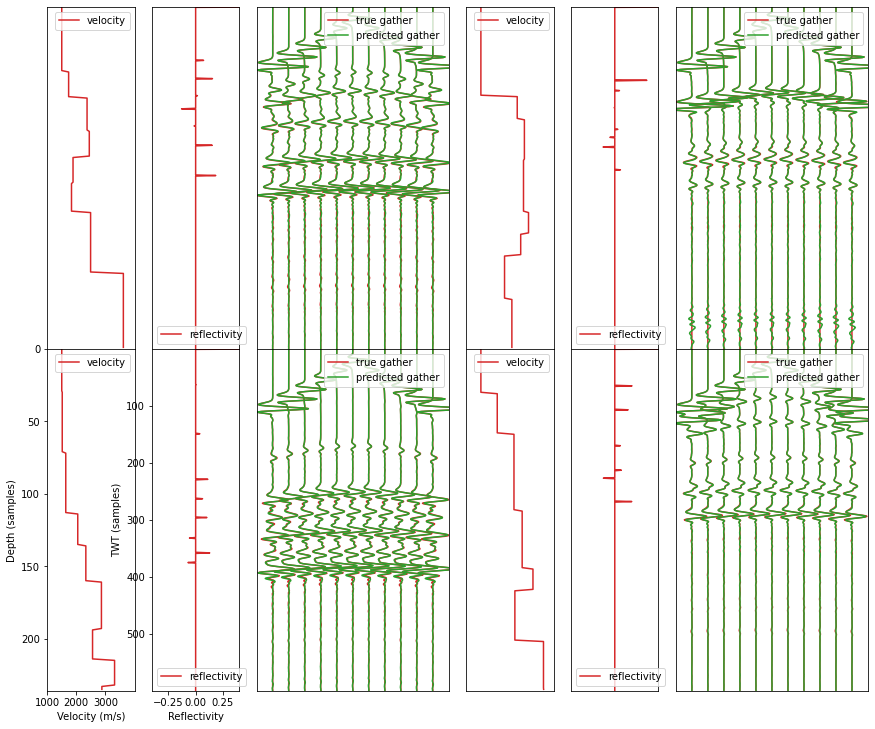

Average prediction time: 0.01820 s


In [17]:
# Hint: to run some predictions, use the following code:

c["DATA_PATH"]="data/layers_8ms.bin"# ensure data path set correctly in loaded constants file

# grab some test data
dataset = datasets.SeismicDataset(c)
velocity_array, reflectivity_array, gather_array = dataset[16000:16004]# the first four examples in the test dataset
print(reflectivity_array.shape)# (Note slicing a SeismicDataset object returns a batch of examples)

# run a model prediction
gather_prediction_array = sess.run(model.y, feed_dict={reflectivity: reflectivity_array})
print(gather_prediction_array.shape)

### TODO: Enter your code to visualise the model predictions here:


model._plot_results(reflectivity_array,
                    gather_prediction_array,
                    gather_array,
                    velocity_array)
plt.show()



### TODO: Enter your code to time the prediction step here:

reflectivity_array = dataset[16000:16100][1]# batch of 100 reflectivity arrays
start = time.time()
gather_prediction_array = sess.run(model.y, feed_dict={reflectivity: reflectivity_array})
print("Average prediction time: %.5f s"%((time.time()-start)/100.))



### Extension (optional): you could try feeding the model velocity models outside of its training data
### distribution e.g. ones with smoothly varying velocity values (instead of layers) - and evaluate 
### how stable the model predictions appear in this case.

# Seção 5: Inversão sísmica (extra opcional)

Também podemos usar a mesma arquitetura WaveNet para realizar a **inversão sísmica** deste conjunto de dados: ou seja, dado um conjunto de gravações do receptor, podemos inverter para o modelo de velocidade subjacente?

Para este modelo, podemos simplesmente **inverter as entradas e saídas** do nosso modelo WaveNet e treinar novamente o modelo!

A classe `models.SeismicWavenet` fornecida é suficiente para lidar com isso; se o modelo realiza modelagem direta ou inversa pode ser controlado pela flag de entrada `SeismicWavenet(inverse=True)`. Ao agrupar `SeismicWavenet` com a classe `main.Trainer`, este sinalizador pode ser definido através da classe `constants.Constants`, ou seja, configurando `c["inverse"]=True`.

> **Tarefa opcional 1**: reutilizar o código acima para treinar um modelo que realiza inversão sísmica.

> **Tarefa opcional 2:** visualize as previsões do seu modelo adaptando o código da Tarefa 7.

Se o treinamento for muito caro, você pode usar o arquivo de modelo pré-treinado e o arquivo de eventos em `data/pretrained/inverse/` fornecidos para ajudá-lo.

INFO:tensorflow:Restoring parameters from pretrained/inverse/model.ckpt-500000


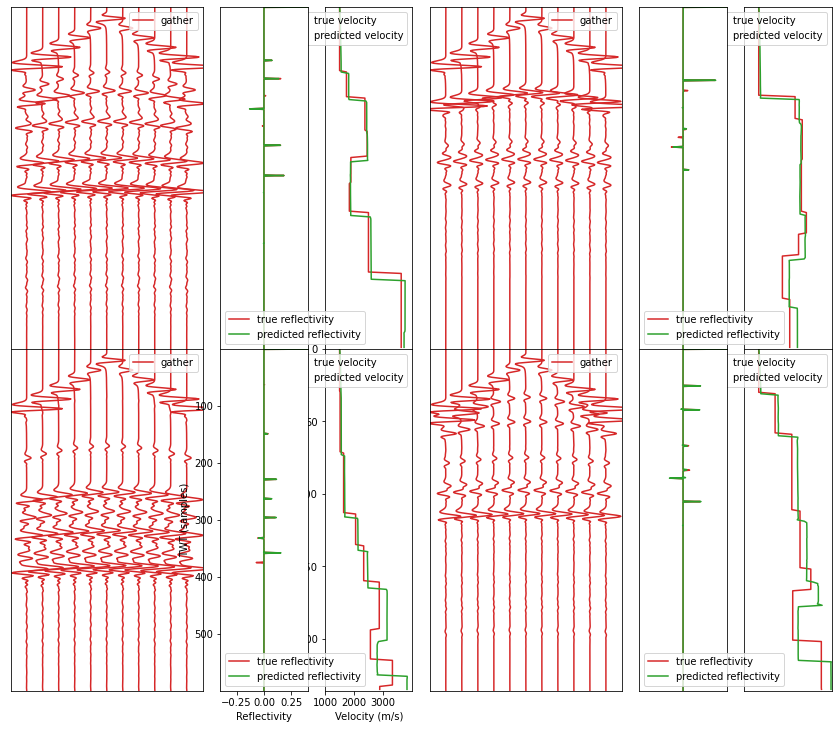

In [18]:
tf.reset_default_graph()

# TODO: Enter your code to train/ visualise the inverse modelling here:
# hint: the processing_utils.get_velocity_trace() function can convert a predicted
# reflectivity series to its corresponding velocity trace

tf.reset_default_graph()

# TODO: Enter your code to train/ visualise the inverse modelling here:
# hint: the processing_utils.get_velocity_trace() function can convert a predicted
# reflectivity series to its corresponding velocity trace


# load pre-trained model
MODEL_LOAD_PATH = "pretrained/inverse/model.ckpt-500000"
CONSTANTS_LOAD_PATH = "pretrained/inverse/constants_inverse.pickle"

# load the model's saved constants object
c_dict = constants.load_constants_dict(CONSTANTS_LOAD_PATH)
c = constants.Constants(**c_dict)

# define model input and output tensorflow placeholders
velocity = tf.placeholder(shape=(None, 236, 1), dtype=tf.float32, name="velocity")
reflectivity = tf.placeholder(shape=(None, 600, 1), dtype=tf.float32, name="reflectivity")
gather = tf.placeholder(shape=(None, 600, 11), dtype=tf.float32, name="gather")
input_features = {"velocity":velocity, "reflectivity": reflectivity, "gather": gather}

# define and load model
model = models.SeismicWavenet(c, input_features)
model.define_graph()
model.define_loss()
saver = tf.train.Saver()# for loading model
sess = tf.Session()
saver.restore(sess, MODEL_LOAD_PATH)# restore weights

# grab some test data, plot results
velocity_array, reflectivity_array, gather_array = dataset[16000:16004]# the first four examples in the test dataset
reflectivity_prediction_array = sess.run(model.y, feed_dict={gather: gather_array})
model._plot_results(gather_array,
                    reflectivity_prediction_array,
                    reflectivity_array,
                    velocity_array)
plt.show()


